# Packages

In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
from tqdm.notebook import tqdm
import itertools
import yaml
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Get the freakin font right

In [2]:
# # List all available fonts
# font_list = fm.findSystemFonts(fontpaths=None, fontext="ttf")

# # Print font file paths and corresponding names
# for font_path in font_list:
#     try:
#         if "lmroman" in font_path:
#             prop = fm.FontProperties(fname=font_path)
#             print(f"Font file: {font_path} => Font name: {prop.get_name()}")
#     except Exception as e:
#         print(f"Error: {e}")

# Load Data

In [3]:
load = (
    pl.read_csv("../0_data/preprocessed/load.csv")
    .with_columns(datetime=(pl.col("datetime").str.to_datetime()))
    .with_columns(pl.col("datetime").dt.truncate("1h"))
    .group_by("datetime")
    .agg(pl.col("kWh").mean() * 4)
    .sort("datetime")
)

load.glimpse()

Rows: 137328
Columns: 2
$ datetime <datetime[μs]> 2009-01-01 00:00:00, 2009-01-01 01:00:00, 2009-01-01 02:00:00, 2009-01-01 03:00:00, 2009-01-01 04:00:00, 2009-01-01 05:00:00, 2009-01-01 06:00:00, 2009-01-01 07:00:00, 2009-01-01 08:00:00, 2009-01-01 09:00:00
$ kWh               <f64> 6984409.355, 6756415.207, 6517087.214, 6226938.271, 5870080.072000001, 5766256.473, 5383379.984999999, 5070821.407, 5036182.316000001, 5229805.461999999



## Fig: Full year

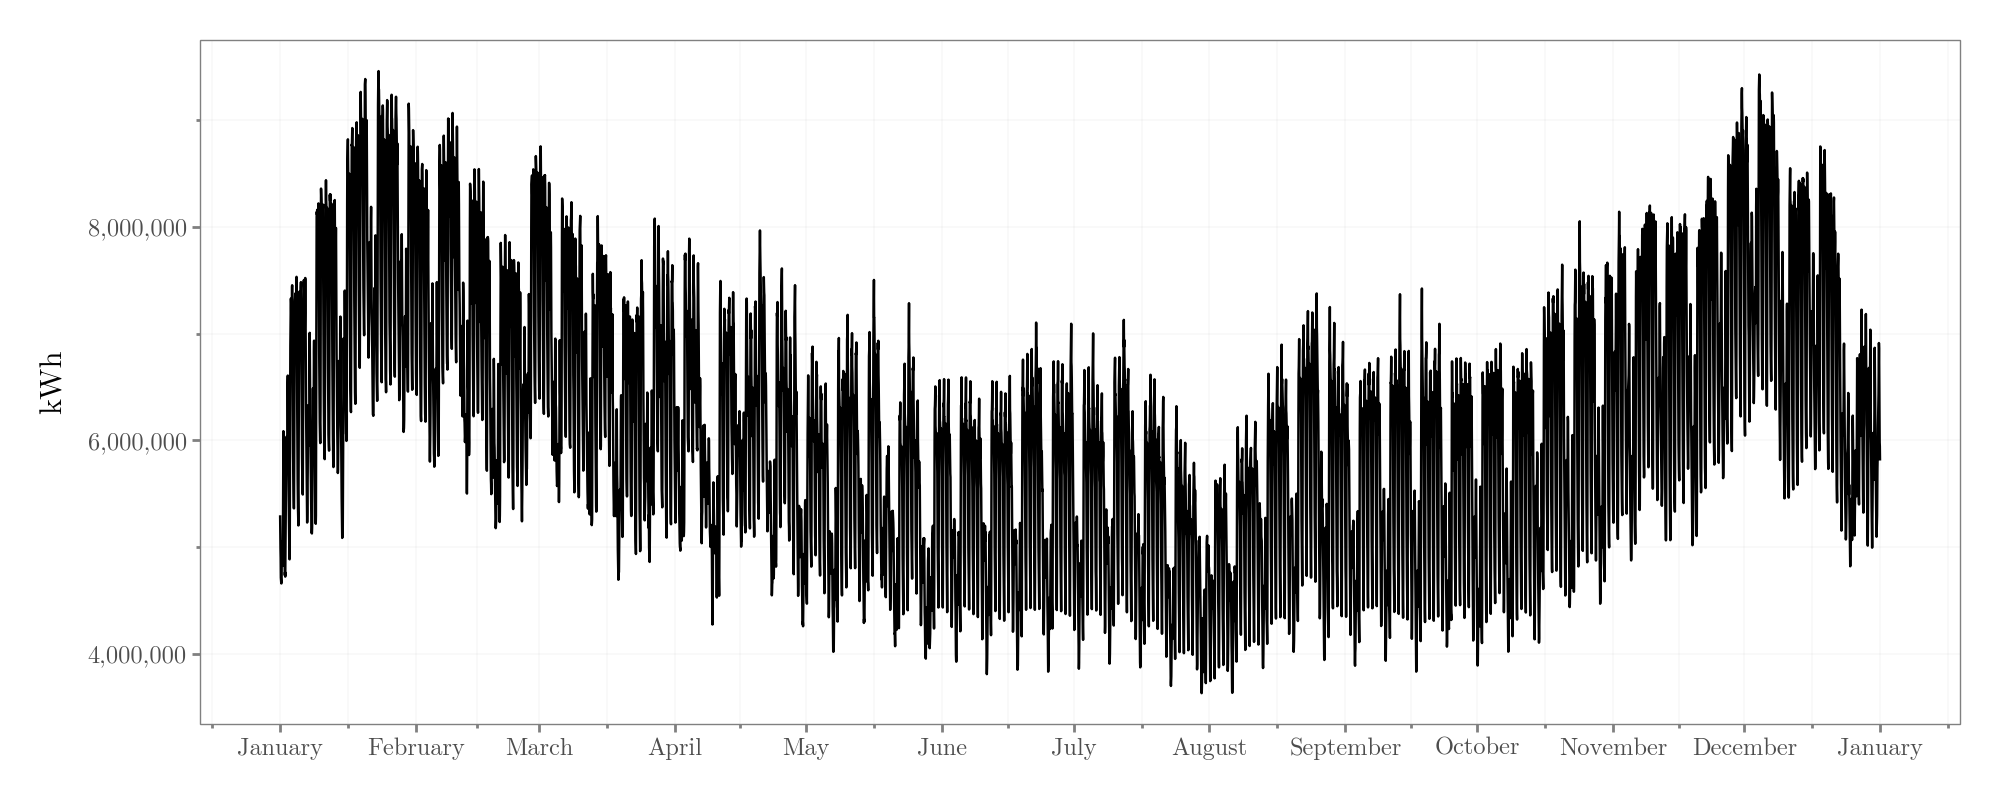

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/load_full_year.pdf


In [4]:
plot_width = 10
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(
                year=pl.col("datetime").dt.year(),
            ).filter(pl.col("year") == 2023)
        ),
        mapping=pn.aes("datetime", "kWh"),
    )
    + pn.geom_line()
    + pn.labs()
    + pn.scale_x_datetime(date_breaks="1 months", date_labels="%B")
    + pn.scale_y_continuous(labels=comma_format())
    # + pn.facet_wrap("~ quarter", ncol=4)
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_position="bottom",
        axis_title_x=pn.element_blank(),
    )
)

display(fig)
fig.save(
    filename="../1_figures/load_full_year.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Trend

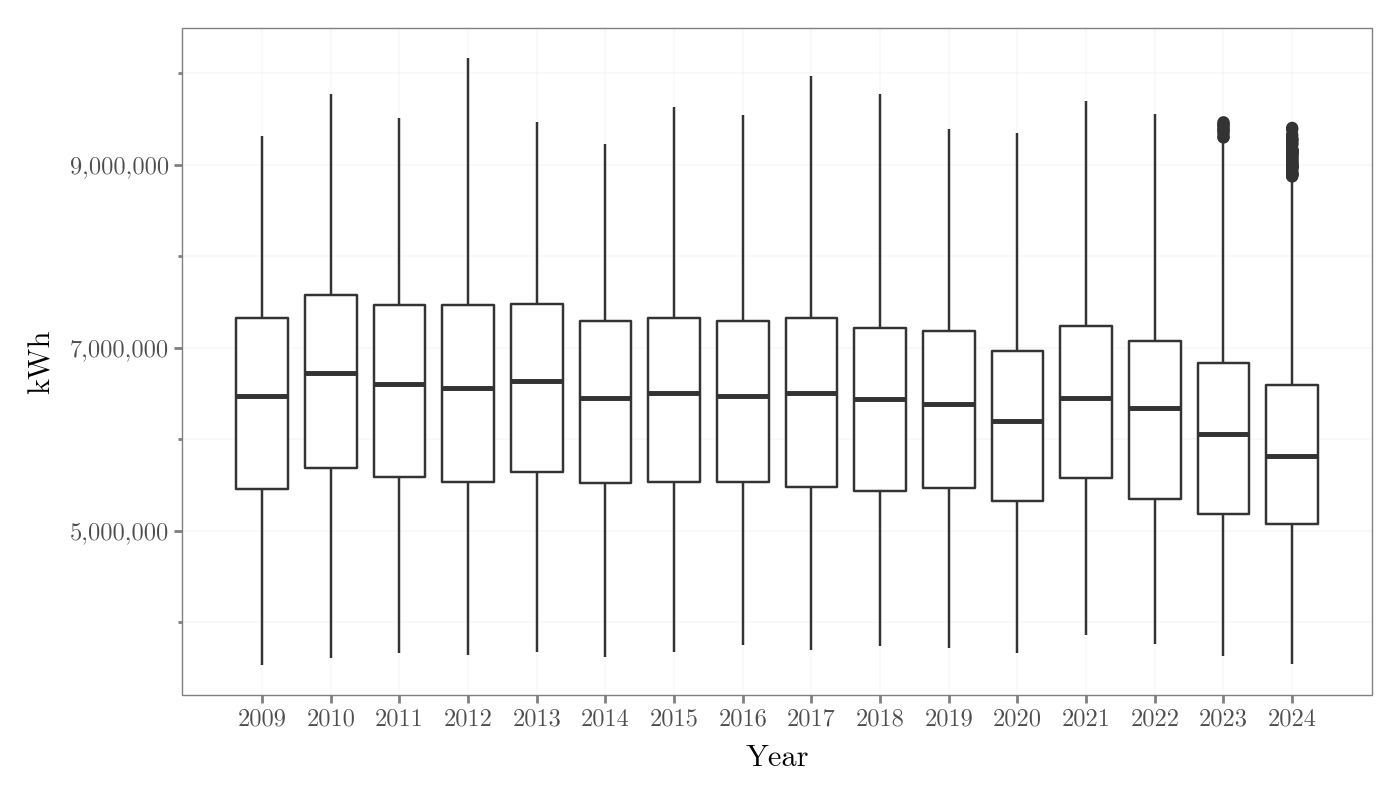

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/load_boxplot_by_year.pdf


In [5]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(
                year=pl.col("datetime").dt.year(),
            )
        ),
        mapping=pn.aes("year", "kWh", group="year"),
    )
    + pn.geom_boxplot()
    + pn.labs(x="Year")
    + pn.scale_x_continuous(breaks=np.arange(2009, 2024 + 1, 1))
    + pn.scale_y_continuous(labels=comma_format())
    # + pn.facet_wrap("~ quarter", ncol=4)
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_position="bottom",
        axis_ticks_minor_x=pn.element_blank(),
        panel_grid_minor_x=pn.element_blank(),
    )
)

display(fig)

fig.save(
    filename="../1_figures/load_boxplot_by_year.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Average by Hour in Day

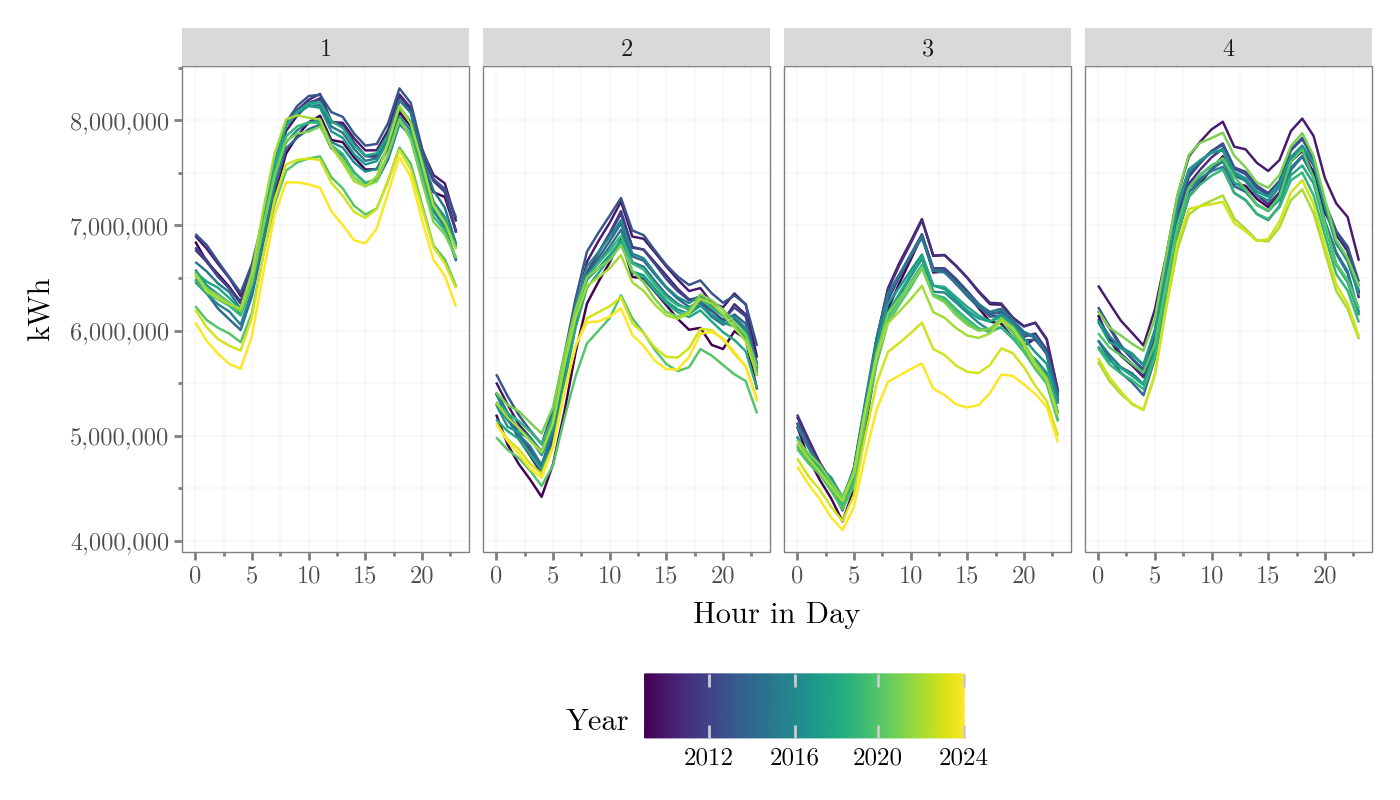

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/consumption_by_quarter_year_hour.pdf


In [6]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(
                hour=pl.col("datetime").dt.hour(),
                year=pl.col("datetime").dt.year(),
                quarter=pl.col("datetime").dt.quarter(),
            )
            .group_by(["hour", "year", "quarter"])
            .agg(pl.mean("kWh"))
        ),
        mapping=pn.aes("hour", "kWh", colour="year", group="year"),
    )
    + pn.geom_line()
    + pn.labs(x="Hour in Day", colour="Year")
    + pn.scale_y_continuous(labels=comma_format())
    + pn.facet_wrap("~ quarter", ncol=4)
    # + pn.scale_colour_gradientn(
    #     colors=["midnightblue", "skyblue", "firebrick"],
    # )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), legend_position="bottom")
)

display(fig)
fig.save(
    filename="../1_figures/consumption_by_quarter_year_hour.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Hour in Day Decade Comparison

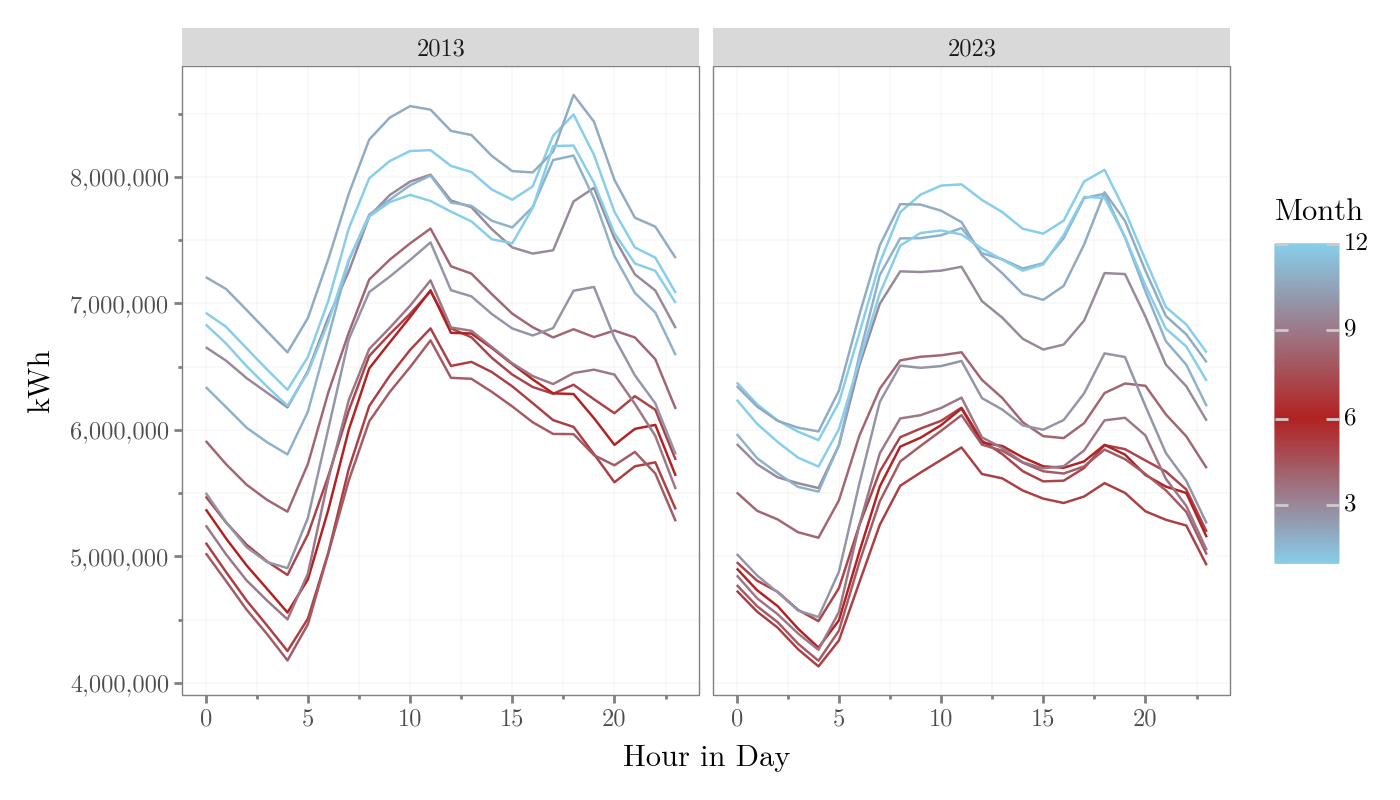

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/daily_profile_decade_shift.pdf


In [7]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(
                year=pl.col("datetime").dt.year(),
                month=pl.col("datetime").dt.month(),
                hour=pl.col("datetime").dt.hour(),
            )
            .filter(pl.col("year").is_in([2013, 2023]))
            .group_by(["year", "month", "hour"])
            .agg(pl.mean("kWh"))
            # .with_columns(
            #     kWh=pl.col("kWh") / pl.col("kWh").max().over(["year", "month"])
            # )
        ),
        mapping=pn.aes("hour", "kWh", colour="month", group="month"),
    )
    + pn.geom_line()
    + pn.facet_wrap("~ year")
    + pn.labs(x="Hour in Day", colour="Month")
    + pn.scale_y_continuous(labels=comma_format())
    + pn.scale_colour_gradientn(
        colors=["skyblue", "firebrick", "skyblue"],
        values=(np.array([1, 6, 12]) - 1) / (12 - 1),
    )
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)


display(fig)
fig.save(
    filename="../1_figures/daily_profile_decade_shift.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Development load by Hour in Day

In [8]:
plot_data = (
    load.with_columns(
        year=pl.col("datetime").dt.year(), hour=pl.col("datetime").dt.hour()
    )
    .group_by(["year", "hour"])
    .agg(pl.mean("kWh"))
    .with_columns(
        colour_code=pl.when(pl.col("hour").is_in(np.arange(8, 20)))
        .then(pl.lit("Peak"))
        .otherwise(pl.lit("Off-Peak"))
    )
    .sort(["year", "hour"])
    .with_columns(kWh=pl.col("kWh") / pl.col("kWh").first().over("hour"))
)

plot_data.head()

year,hour,kWh,colour_code
i32,i8,f64,str
2009,0,1.0,"""Off-Peak"""
2009,1,1.0,"""Off-Peak"""
2009,2,1.0,"""Off-Peak"""
2009,3,1.0,"""Off-Peak"""
2009,4,1.0,"""Off-Peak"""


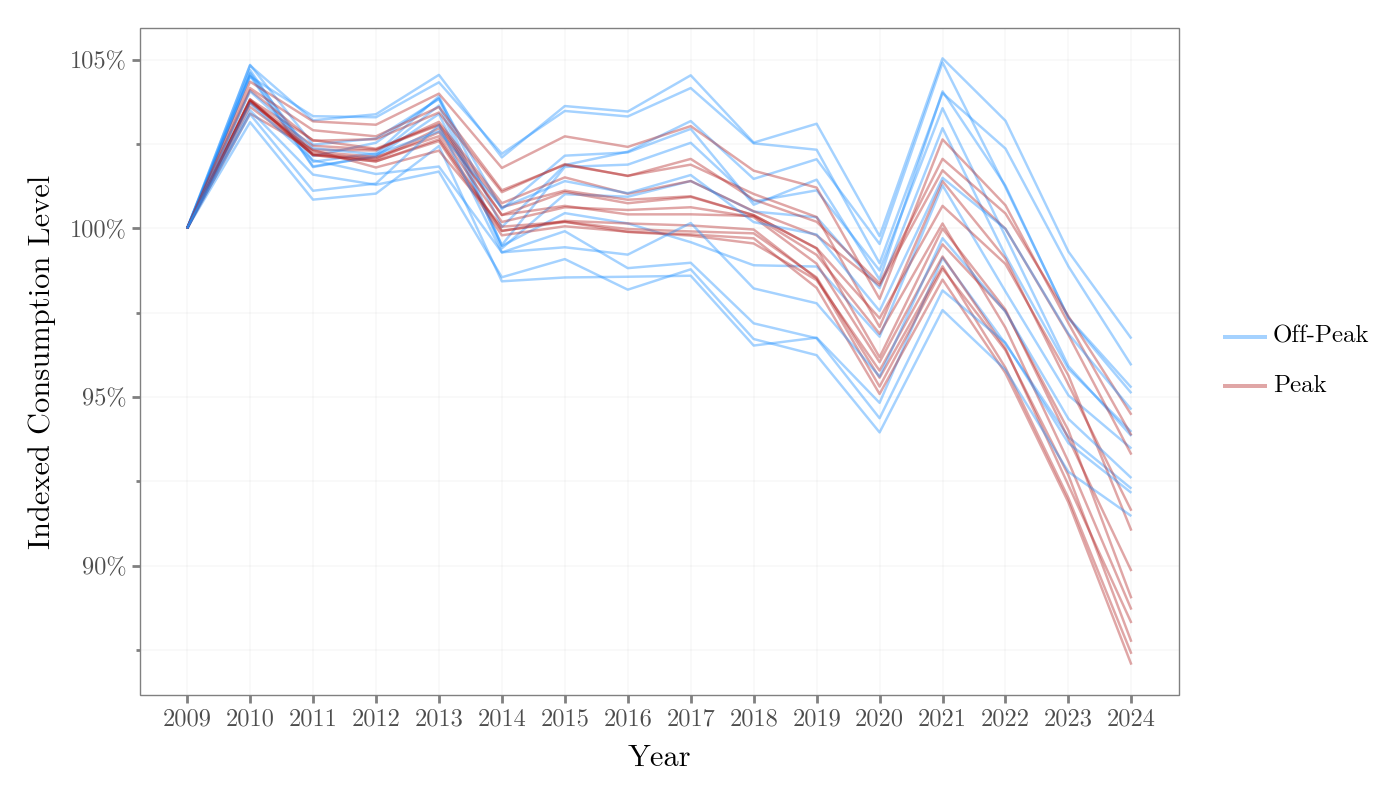

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/index-consumption-by-year.pdf


In [9]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=plot_data,
        mapping=pn.aes("year", "kWh", group="hour", colour="colour_code"),
    )
    + pn.geom_line(alpha=0.4)
    + pn.labs(x="Year", y="Index")
    + pn.labs(
        # title="Indexed Hourly Load by Year and Time of Day",
        # subtitle="Every line represents one of 24 hours in a day, indexed to 2009\nPeak is defined as 08:00-18:00 CET",
        x="Year",
        y="Indexed Consumption Level",
    )
    + pn.scale_x_continuous(breaks=np.arange(2009, 2025))
    + pn.scale_y_continuous(labels=percent_format())
    + pn.scale_colour_manual(values=["dodgerblue", "firebrick"])
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_title=pn.element_blank(),
        plot_title=pn.element_text(ha="left"),
        plot_subtitle=pn.element_text(ha="left", lineheight=1.25),
        axis_ticks_minor_x=pn.element_blank(),
        panel_grid_minor_x=pn.element_blank(),
    )
)


display(fig)
fig.save(
    filename="../1_figures/index-consumption-by-year.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Year and Weekday vs Weekend Comparison

In [10]:
plot_data = (
    load.with_columns(
        weekday=pl.col("datetime").dt.weekday(),
        day=pl.col("datetime").dt.ordinal_day(),
        year=pl.col("datetime").dt.year(),
    )
    .filter(pl.col("year") >= 2021)
    .with_columns(
        category=(
            pl.when(pl.col("weekday").is_in(np.arange(1, 6)))
            .then(pl.lit("Workday"))
            .when(pl.col("weekday") == 6)
            .then(pl.lit("Saturday"))
            .when(pl.col("weekday") == 7)
            .then(pl.lit("Sunday"))
        )
    )
    .group_by(["category", "day", "year"])
    .agg(pl.mean("kWh"))
)
plot_data.head()

category,day,year,kWh
str,i16,i32,f64
"""Workday""",130,2022,6.0788e6
"""Saturday""",112,2023,5.5240e6
"""Workday""",98,2021,6.9491e6
"""Workday""",22,2024,7.8663e6
"""Workday""",245,2022,5.9093e6


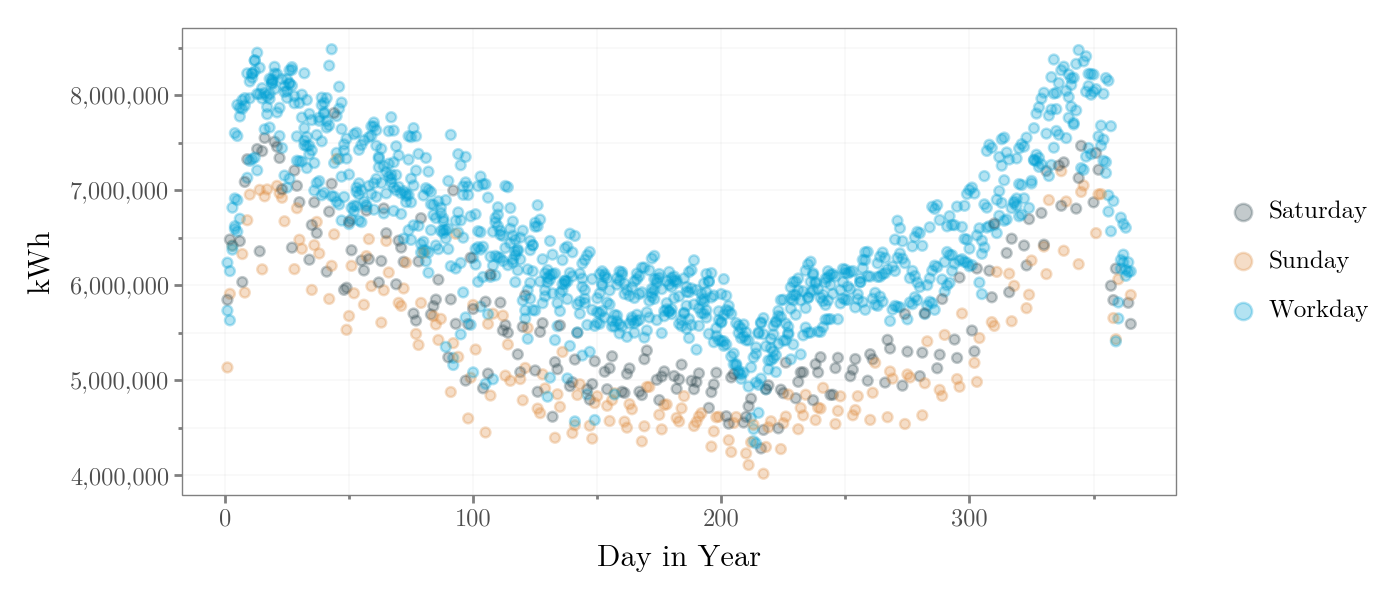

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/daily-consumption-by-daytype.pdf


In [11]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(
        data=plot_data,
        mapping=pn.aes("day", "kWh", colour="category"),
    )
    + pn.geom_point(alpha=0.3)
    + pn.scale_y_continuous(labels=comma_format())
    + pn.labs(x="Day in Year")
    # + pn.scale_colour_gradientn(
    #     colors=["skyblue", "firebrick", "skyblue"],
    #     values=(np.array([1, 6, 12]) - 1) / (12 - 1),
    # )
    + pn.scale_colour_manual(values=jama_colour[:3])
    + pn.guides(color=pn.guide_legend(override_aes={"size": 3}))
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), legend_title=pn.element_blank())
)


display(fig)
fig.save(
    filename="../1_figures/daily-consumption-by-daytype.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Daily Profile by Workday, Weekend and Holiday

In [12]:
import holidays

In [13]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(years=load["datetime"].dt.year().unique().to_list())
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "date": list(regional_holidays.keys()),
    }
)

In [14]:
holiday_df.head()

holiday_name,date
str,date
"""Neujahrestag""",2016-01-01
"""Auffahrt""",2016-05-05
"""Nationalfeiertag""",2016-08-01
"""Weihnachten""",2016-12-25
"""Neujahrestag""",2017-01-01


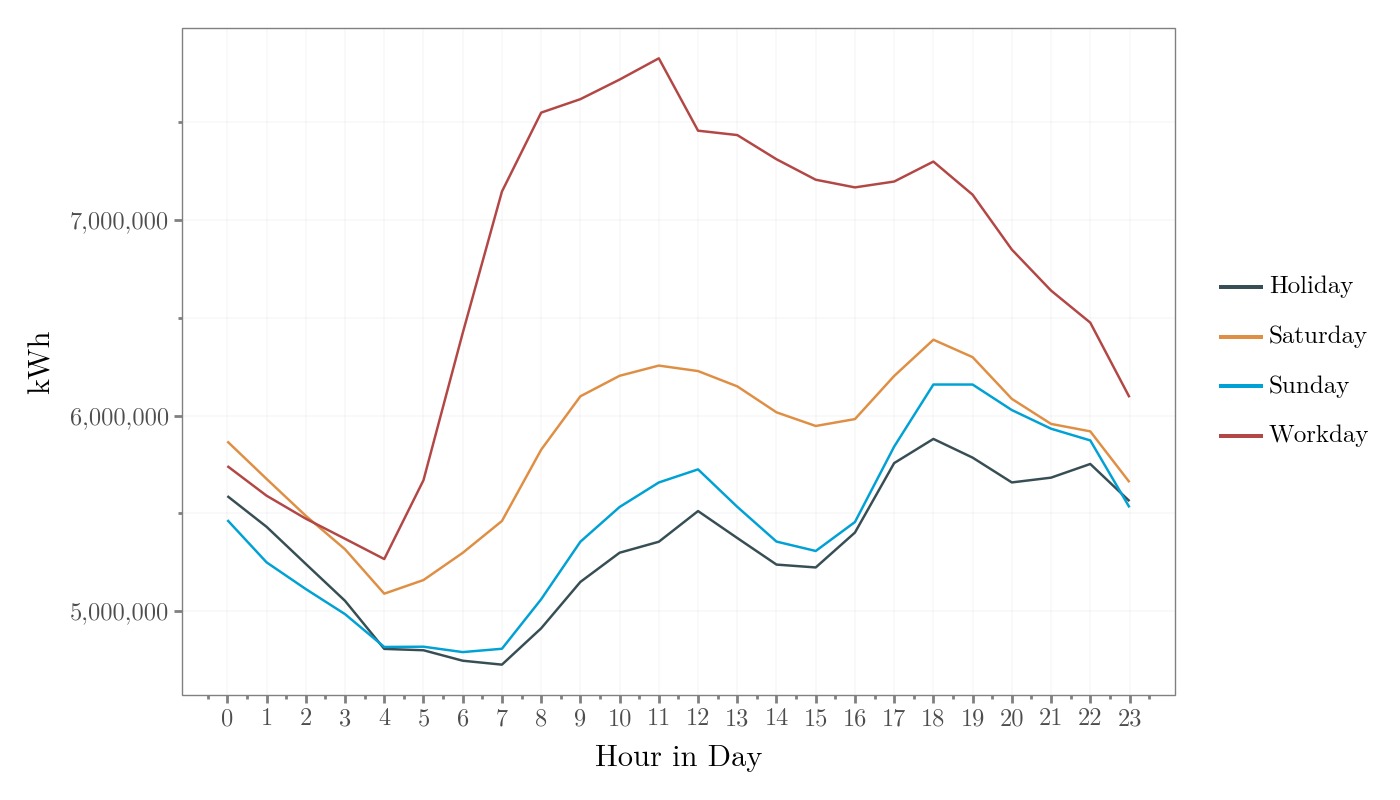

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/daily_profile_by_holiday_workday_saturday_sunday.pdf


In [15]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(date=pl.col("datetime").dt.date())
            .join(holiday_df, how="left", on="date")
            .with_columns(
                Holiday=pl.when(pl.col("holiday_name").is_null())
                .then(pl.lit(0))
                .otherwise(pl.lit(1)),
                Workday=(
                    pl.when(pl.col("datetime").dt.weekday().is_in(np.arange(1, 6)))
                    .then(pl.lit(1))
                    .otherwise(pl.lit(0))
                ),
                Saturday=(
                    pl.when(pl.col("datetime").dt.weekday().is_in([6]))
                    .then(pl.lit(1))
                    .otherwise(pl.lit(0))
                ),
                Sunday=(
                    pl.when(pl.col("datetime").dt.weekday().is_in([7]))
                    .then(pl.lit(1))
                    .otherwise(pl.lit(0))
                ),
            )
            .drop("date", "holiday_name")
            .unpivot(index=["datetime", "kWh"])
            .filter(pl.col("value") == 1)
            .with_columns(hour=pl.col("datetime").dt.hour())
            .group_by("variable", "hour")
            .agg(pl.col("kWh").mean())
        ),
        mapping=pn.aes("hour", "kWh", colour="variable"),
    )
    + pn.geom_line()
    + pn.labs(x="Hour in Day")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_continuous(breaks=np.arange(0, 24))
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_title=pn.element_blank(),
        panel_grid_minor_x=pn.element_blank(),
    )
)


display(fig)
fig.save(
    filename="../1_figures/daily_profile_by_holiday_workday_saturday_sunday.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Heatmap of Day in Year and Hour in Day

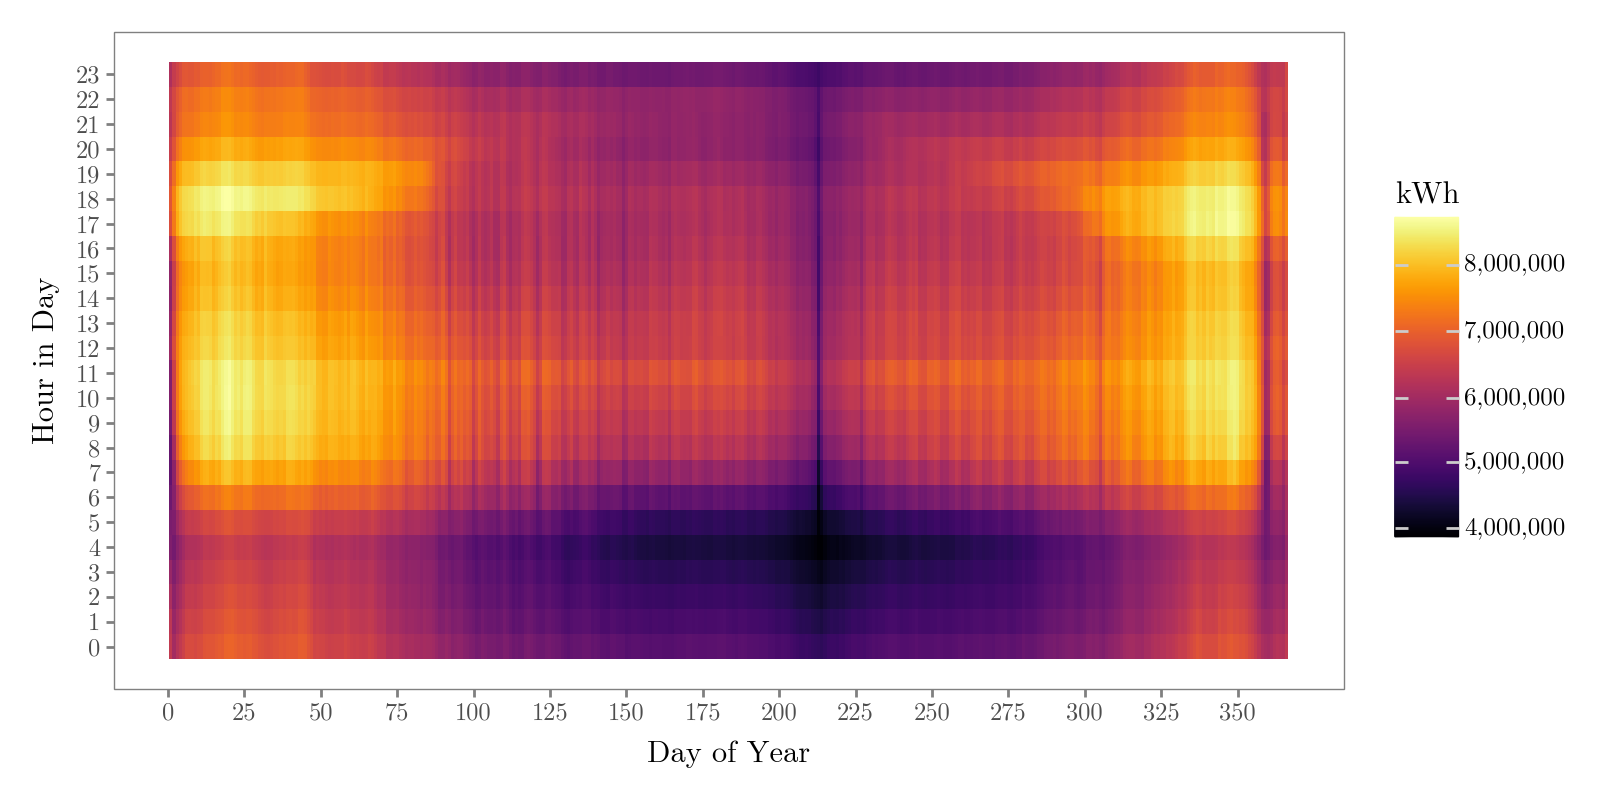

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/heatmap_yearday_hour.pdf


In [24]:
plot_width = 8
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load
            # .filter(pl.col("datetime").dt.year() >= 2021)
            # .with_columns(pl.col("datetime").dt.convert_time_zone("UTC"))
            .with_columns(
                hour=pl.col("datetime").dt.hour(),
                doy=pl.col("datetime").dt.ordinal_day(),
            )
            .group_by(["hour", "doy"])
            .agg(pl.mean("kWh"))
        ),
        mapping=pn.aes("doy", "hour", fill="kWh"),
    )
    + pn.geom_tile()
    + pn.labs(
        # title="Swiss End-User Electricity Consumption: Hourly Usage Patterns Throughout Weekdays",
        # subtitle="Averages are formed based on historical data from the period 2009-2022",
        x="Day of Year",
        y="Hour in Day",
        # fill="Mean Consumption:",
    )
    + pn.scale_x_continuous(breaks=np.arange(0, 365, 25))
    + pn.scale_y_continuous(breaks=np.arange(0, 24, 1))
    + pn.scale_fill_cmap(cmap_name="inferno", labels=comma_format())
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        panel_grid=pn.element_blank(),
        axis_ticks_minor=pn.element_blank(),
    )
)


display(fig)
fig.save(
    filename="../1_figures/heatmap_yearday_hour.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Heatmap of Day in Week and Hour in Day

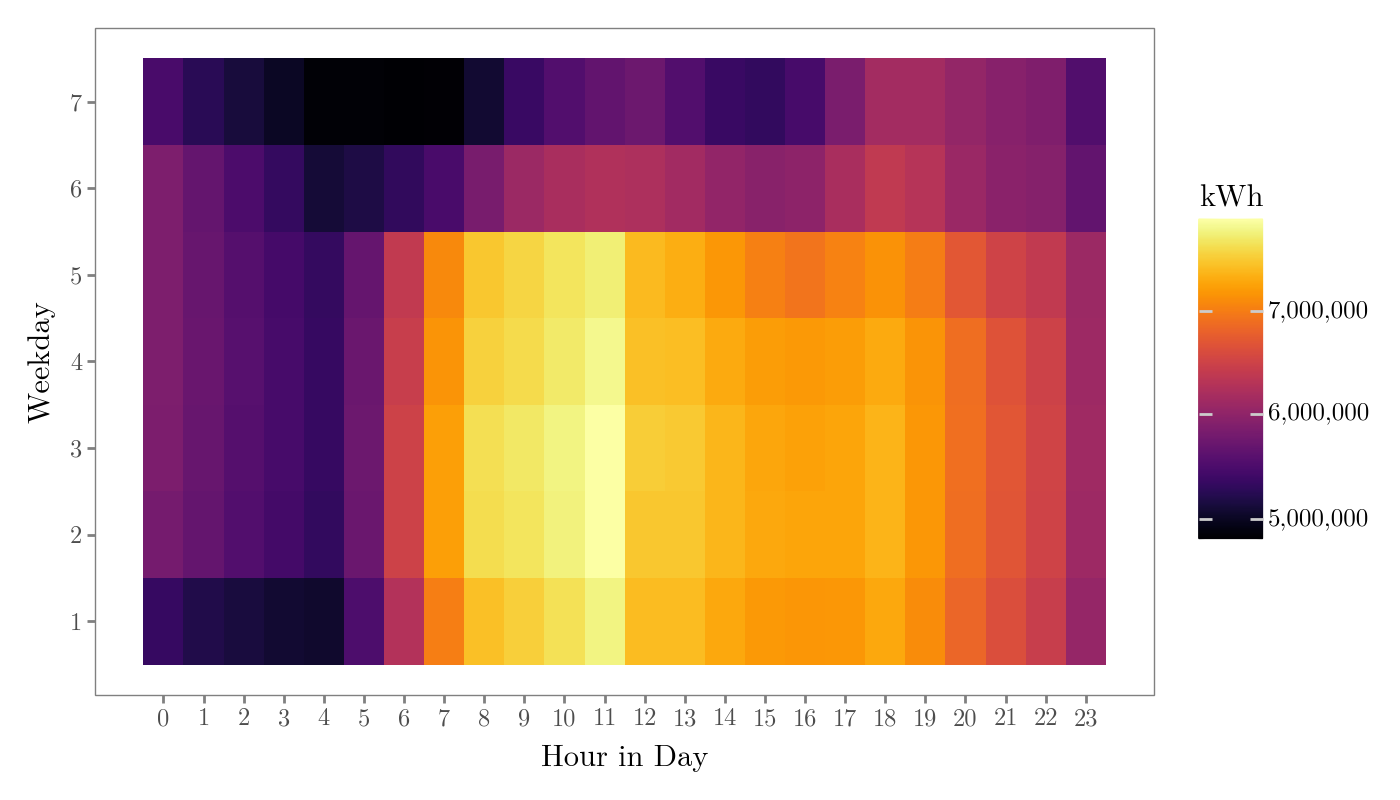

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/heatmap_weekday_hour.pdf


In [25]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            load.with_columns(
                hour=pl.col("datetime").dt.hour(), day=pl.col("datetime").dt.weekday()
            )
            .group_by(["hour", "day"])
            .agg(pl.mean("kWh"))
        ),
        mapping=pn.aes("hour", "day", fill="kWh"),
    )
    + pn.geom_tile()
    + pn.labs(
        # title="Swiss End-User Electricity Consumption: Hourly Usage Patterns Throughout Weekdays",
        # subtitle="Averages are formed based on historical data from the period 2009-2022",
        y="Weekday",
        x="Hour in Day",
        # fill="Mean Consumption:",
    )
    + pn.scale_x_continuous(breaks=np.arange(0, 24))
    + pn.scale_y_continuous(breaks=np.arange(0, 8))
    # + pn.scale_fill_distiller(type="seq", direction=1, labels=comma_format())
    + pn.scale_fill_cmap(cmap_name="inferno", labels=comma_format())
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        panel_grid=pn.element_blank(),
        axis_ticks_minor=pn.element_blank(),
    )
)


display(fig)
fig.save(
    filename="../1_figures/heatmap_weekday_hour.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

# Balance Energy Prices

$$ \frac{ct}{kWh} = \frac{0.01 * EUR}{0.001 * MWh} = \frac{0.01}{0.001} * \frac{EUR}{MWh} = 10 * \frac{EUR}{MWh}  $$

$$ \frac{EUR}{MWh} = \frac{ct}{kWh} * \frac{1}{10} $$

In [18]:
balance = (
    pl.read_csv("../0_data/preprocessed/balance_energy_price.csv", try_parse_dates=True)
    .with_columns(
        long_EUR_MWh=10 * pl.col("long_ct_kWh"),
        short_EUR_MWh=10 * pl.col("short_ct_kWh"),
    )
    .drop(cs.contains("ct"))
    .with_columns(
        pl.col("datetime").dt.replace_time_zone("Europe/Brussels", ambiguous="earliest")
    )
)

balance.head()

datetime,long_EUR_MWh,short_EUR_MWh
"datetime[μs, Europe/Brussels]",f64,f64
2020-12-01 00:00:00 CET,27.9,72.8
2020-12-01 00:15:00 CET,27.9,72.8
2020-12-01 00:30:00 CET,27.9,72.8
2020-12-01 00:45:00 CET,27.9,68.8
2020-12-01 01:00:00 CET,26.2,72.8


In [19]:
spot = pl.read_csv(
    "../0_data/preprocessed/day_ahead_prices_ch.csv", try_parse_dates=True
).with_columns(pl.col("date").dt.convert_time_zone("Europe/Brussels"))

spot.head()

date,da_spot_ch_eur_mwh
"datetime[μs, Europe/Brussels]",f64
2015-01-01 00:00:00 CET,44.94
2015-01-01 01:00:00 CET,43.43
2015-01-01 02:00:00 CET,38.08
2015-01-01 03:00:00 CET,35.47
2015-01-01 04:00:00 CET,30.83


## Fig: Comparison to Spot Price

In [20]:
df = (
    balance.with_columns(date=pl.col("datetime").dt.truncate("1h"))
    .join(spot, how="left", left_on="date", right_on="date")
    .drop_nulls("da_spot_ch_eur_mwh")
    .drop("date")
)

df.head()

datetime,long_EUR_MWh,short_EUR_MWh,da_spot_ch_eur_mwh
"datetime[μs, Europe/Brussels]",f64,f64,f64
2020-12-01 00:00:00 CET,27.9,72.8,44.94
2020-12-01 00:15:00 CET,27.9,72.8,44.94
2020-12-01 00:30:00 CET,27.9,72.8,44.94
2020-12-01 00:45:00 CET,27.9,68.8,44.94
2020-12-01 01:00:00 CET,26.2,72.8,42.63


In [21]:
plot_data = (
    df.with_columns(
        short_gap=(pl.col("short_EUR_MWh") - pl.col("da_spot_ch_eur_mwh")),
        long_gap=(pl.col("long_EUR_MWh") - pl.col("da_spot_ch_eur_mwh")),
    ).select("datetime", "short_gap", "long_gap")
    # .unpivot()
)

plot_data.head()

datetime,short_gap,long_gap
"datetime[μs, Europe/Brussels]",f64,f64
2020-12-01 00:00:00 CET,27.86,-17.04
2020-12-01 00:15:00 CET,27.86,-17.04
2020-12-01 00:30:00 CET,27.86,-17.04
2020-12-01 00:45:00 CET,23.86,-17.04
2020-12-01 01:00:00 CET,30.17,-16.43


In [22]:
plot_data["long_gap"].max()

-5.0

In [23]:
plot_data["short_gap"].min()

5.04

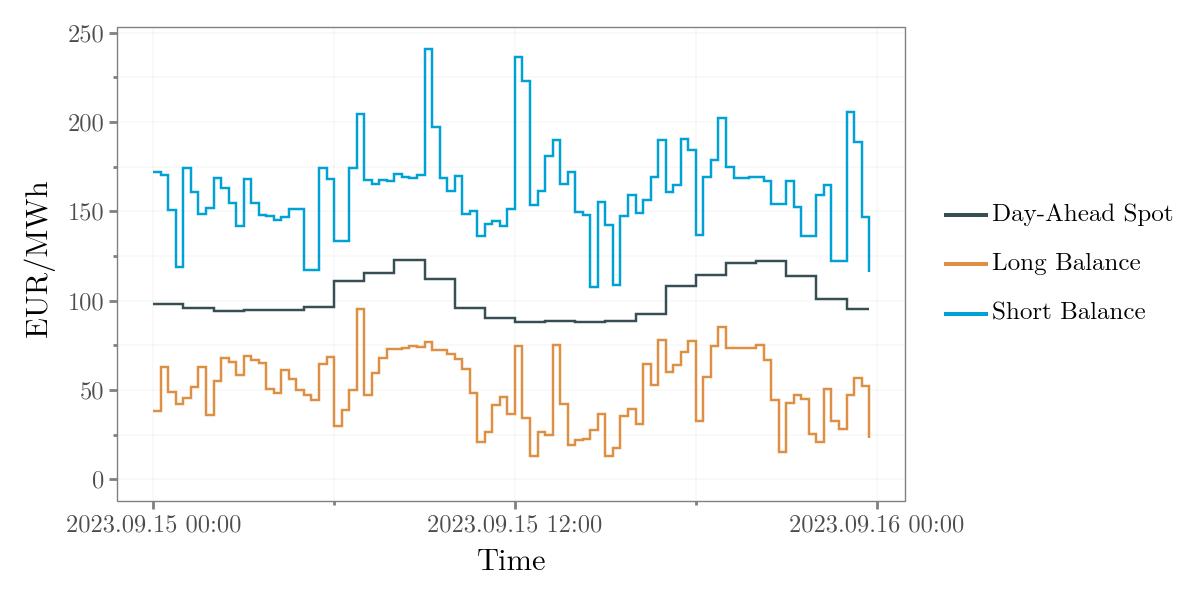

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 3 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/control_spot_comparison.pdf


In [24]:
plot_width = 6
plot_height = 3

fig = (
    pn.ggplot(
        data=(
            df.filter(
                pl.col("datetime")
                >= pd.Timestamp("2023-09-15 00:00", tz="Europe/Brussels")
            )
            .rename(
                {
                    "long_EUR_MWh": "Long Balance",
                    "short_EUR_MWh": "Short Balance",
                    "da_spot_ch_eur_mwh": "Day-Ahead Spot",
                }
            )
            .slice(offset=0, length=96)
            .unpivot(index="datetime")
        ),
        mapping=pn.aes("datetime", "value", colour="variable"),
    )
    + pn.geom_step()
    + pn.labs(x="Time", y=" EUR/MWh")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_datetime(date_labels="%Y.%m.%d %H:%M", date_breaks="12 hours")
    # + pn.scale_y_continuous(labels=comma_format(suffix=" EUR/MWh"))
    + pn.expand_limits(y=0)
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_title=pn.element_blank(),
        # axis_title_y=pn.element_blank(),
    )
)

display(fig)
fig.save(
    filename="../1_figures/control_spot_comparison.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Fig: Boxplot of Balance Energy Prices

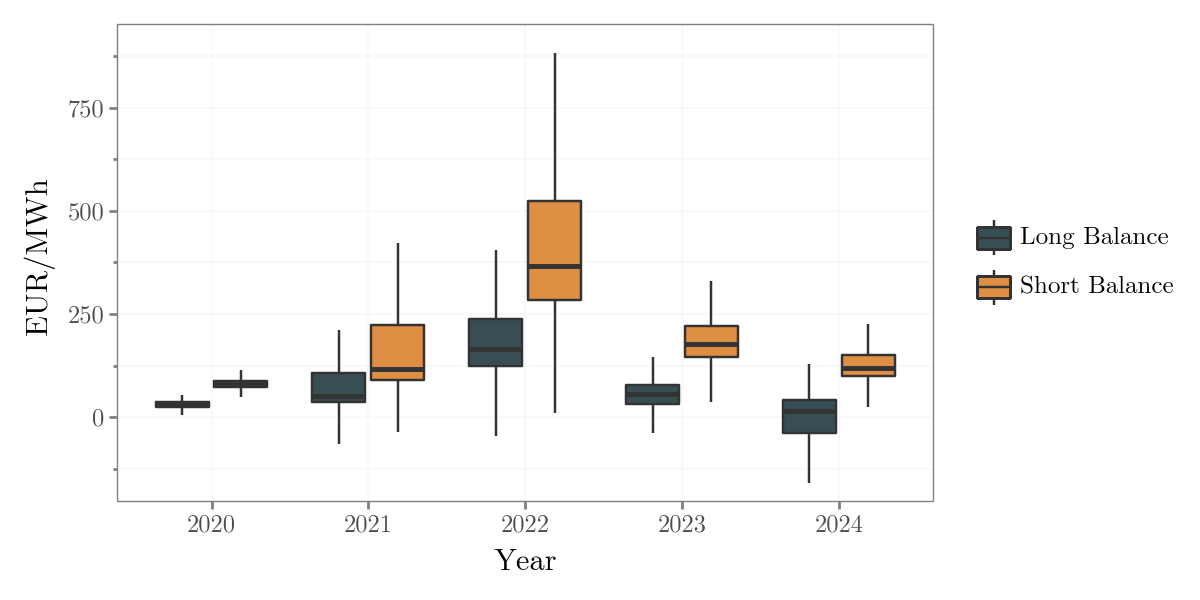

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 3 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/balance_prices_boxplot.pdf


In [25]:
plot_width = 6
plot_height = 3

fig = (
    pn.ggplot(
        data=(
            balance.with_columns(year=pl.col("datetime").dt.year())
            .drop("datetime")
            .rename(
                {
                    "long_EUR_MWh": "Long Balance",
                    "short_EUR_MWh": "Short Balance",
                }
            )
            .unpivot(index="year")
        ),
        mapping=pn.aes(x="factor(year)", y="value", fill="variable"),
    )
    + pn.geom_boxplot(outlier_colour="none")
    + pn.labs(x="Year", y=" EUR/MWh")
    + pn.coord_cartesian(ylim=[-150, 900])
    + pn.scale_fill_manual(values=jama_colour)
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        legend_title=pn.element_blank(),
        # axis_title_x=pn.element_blank(),
    )
)

display(fig)
fig.save(
    filename="../1_figures/balance_prices_boxplot.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Tab: Balance price summary statistics

In [26]:
balance.to_pandas().describe()

,long_EUR_MWh,short_EUR_MWh
count,131536.000000,131536.000000
mean,68.262570,236.949083
std,259.267424,237.436756
min,-16505.500000,-380.300000
25%,32.300000,114.400000
50%,58.100000,176.600000
75%,129.700000,297.600000
max,731.600000,14864.600000


In [27]:
balance.to_pandas().describe().to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n & long_EUR_MWh & short_EUR_MWh \\\\\n\\midrule\ncount & 131536.000000 & 131536.000000 \\\\\nmean & 68.262570 & 236.949083 \\\\\nstd & 259.267424 & 237.436756 \\\\\nmin & -16505.500000 & -380.300000 \\\\\n25% & 32.300000 & 114.400000 \\\\\n50% & 58.100000 & 176.600000 \\\\\n75% & 129.700000 & 297.600000 \\\\\nmax & 731.600000 & 14864.600000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Fig: Balance Costs Summary

In [28]:
df = (
    balance.with_columns(date=pl.col("datetime").dt.truncate("1h"))
    .join(spot, how="left", left_on="date", right_on="date")
    .drop_nulls("da_spot_ch_eur_mwh")
    .drop("date")
)

df.head()

datetime,long_EUR_MWh,short_EUR_MWh,da_spot_ch_eur_mwh
"datetime[μs, Europe/Brussels]",f64,f64,f64
2020-12-01 00:00:00 CET,27.9,72.8,44.94
2020-12-01 00:15:00 CET,27.9,72.8,44.94
2020-12-01 00:30:00 CET,27.9,72.8,44.94
2020-12-01 00:45:00 CET,27.9,68.8,44.94
2020-12-01 01:00:00 CET,26.2,72.8,42.63


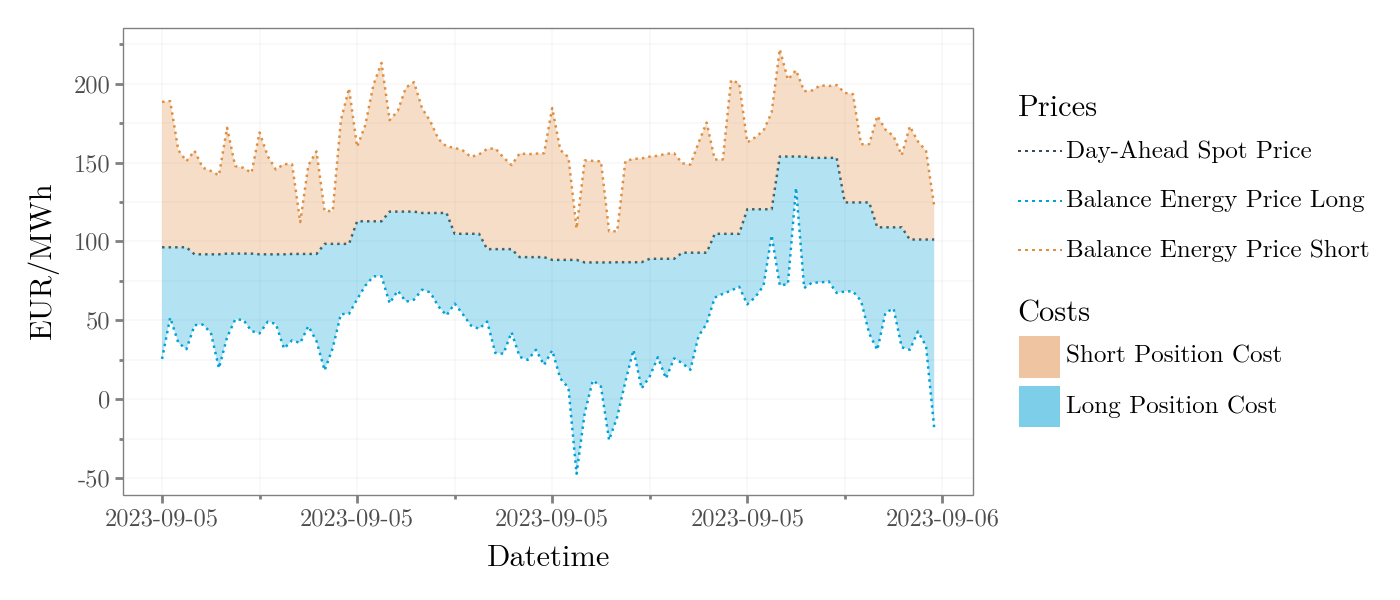

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 3 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/balance_costs_schema.pdf


In [29]:
plot_width = 7
plot_height = 3

fig = (
    pn.ggplot(
        data=df.filter(pl.col("datetime").dt.date() == pd.to_datetime("2023-09-05")),
        mapping=pn.aes(x="datetime"),
    )
    + pn.geom_line(
        mapping=pn.aes(y="da_spot_ch_eur_mwh", color="'Day-Ahead Spot Price'"),
        linetype="dotted",
    )
    + pn.geom_line(
        mapping=pn.aes(y="long_EUR_MWh", color="'Balance Energy Price Long'"),
        linetype="dotted",
    )
    + pn.geom_line(
        mapping=pn.aes(y="short_EUR_MWh", color="'Balance Energy Price Short'"),
        linetype="dotted",
    )
    + pn.geom_ribbon(
        mapping=pn.aes(
            ymin="da_spot_ch_eur_mwh",
            ymax="short_EUR_MWh",
            fill="'Short Position Cost'",
        ),
        alpha=0.3,
    )
    + pn.geom_ribbon(
        mapping=pn.aes(
            ymax="da_spot_ch_eur_mwh", ymin="long_EUR_MWh", fill="'Long Position Cost'"
        ),
        alpha=0.3,
    )
    + pn.scale_color_manual(
        values={
            "Day-Ahead Spot Price": jama_colour[0],
            "Balance Energy Price Short": jama_colour[1],
            "Balance Energy Price Long": jama_colour[2],
        }
    )
    + pn.scale_fill_manual(
        values={
            "Short Position Cost": jama_colour[1],
            "Long Position Cost": jama_colour[2],
        }
    )
    + pn.labs(y="EUR/MWh", x="Datetime", colour="Prices", fill="Costs")
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
    )
)

display(fig)
fig.save(
    filename="../1_figures/balance_costs_schema.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)